In [1]:
import pde
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
import torch
import h5py
import xarray as xr
import multiprocessing as mp
from ks import get_sim

# Single PDE test

In [2]:
n_cores= mp.cpu_count()-6

In [189]:
L = 128
grid_upper = 50
# make 1D grid
grid = pde.CartesianGrid([(0, grid_upper)], [L], periodic=True)
state = pde.ScalarField.random_normal(grid, mean = 0)  # generate initial condition

eq = pde.PDE({"u": "-u * d_dx(u) / 2 - laplace(u + laplace(u))"})


# solve the system
storage = pde.MemoryStorage()
result = eq.solve(
state,
t_range=150,
dt=0.001,
adaptive=True,
tracker=[storage.tracker(0.1)],
)

res = np.array(storage.data)

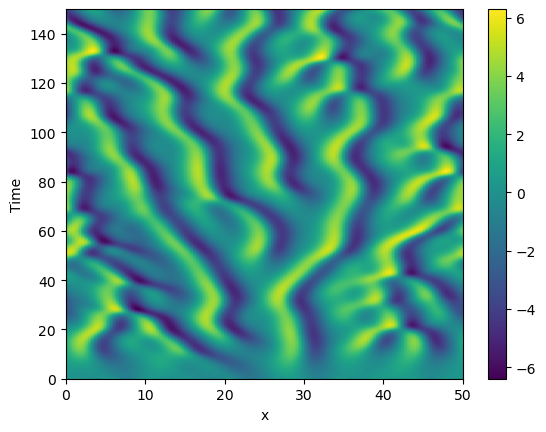

In [190]:
pde.plot_kymograph(storage)

In [164]:
L = 64
n_steps = [i*10+1 for i in range(15)]
n_sim = 50
grid_upper = 50

grid = pde.CartesianGrid([(0, grid_upper), (0, grid_upper)], [L,L], periodic = True)

In [19]:
state = pde.ScalarField.random_normal(grid, mean = 0)  # generate initial condition
n_steps = [i*2+10 for i in range(15)]

# Create 2d datagrid with values from 0, 50 per variable
x = np.linspace(0, 50, L)
y = np.linspace(0, 50, L)
X, Y = np.meshgrid(x, y)
u = np.random.uniform(0, 2*np.pi,3)
data = np.sin(np.pi/25*(X+Y)+u[0])+np.sin(np.pi/25*X+u[1])+np.sin(np.pi/25*Y+u[2])
state = pde.ScalarField(grid, data = data)

eq = pde.PDE({"u": "-gradient_squared(u) / 2 - laplace(u + laplace(u))"})  # define the pde


# solve the system
storage = pde.MemoryStorage()
result = eq.solve(
state,
t_range=150,
dt=0.001,
adaptive=True,
tracker=[storage.tracker(n_steps)],
)

res = np.array(storage.data)

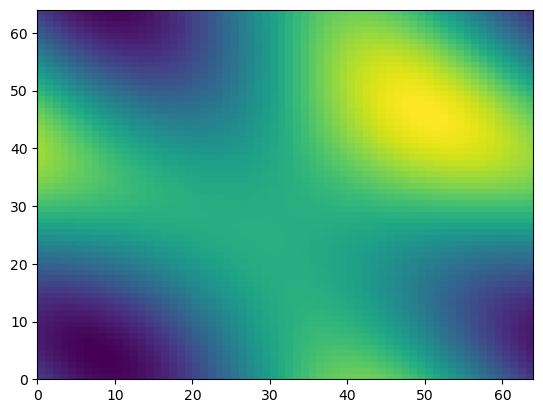

In [20]:
plt.pcolormesh(state.data)

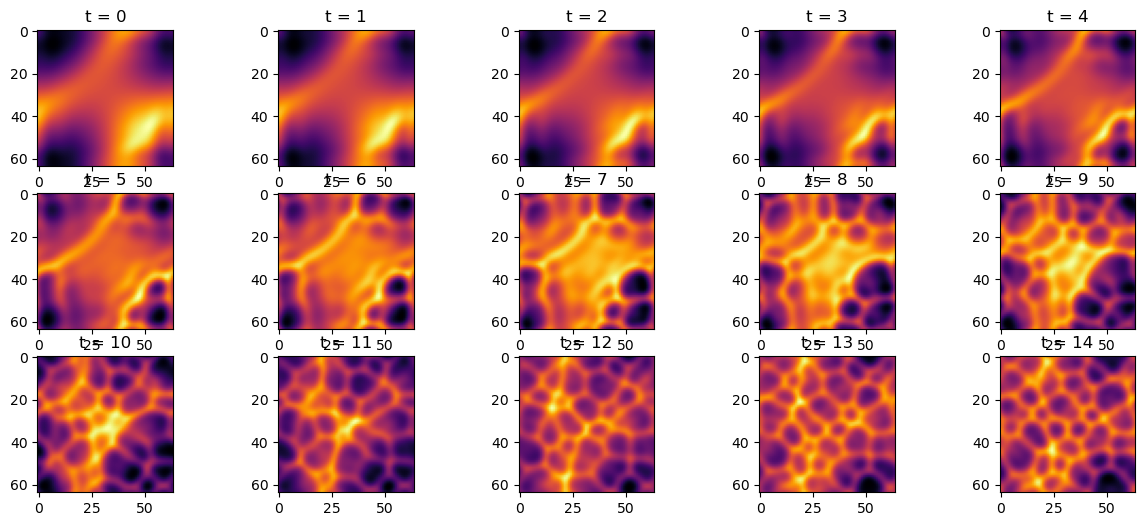

In [21]:
fig, axs = plt.subplots(3,5, figsize = (15,6))
axs= axs.ravel()

for i in range(res.shape[0]):
    axs[i].imshow(res[i], cmap = "inferno")
    axs[i].set_title("t = " + str(i))

# 1d Kuramoto-Sivashinksky PDE

In [ ]:
L = 128
n_sim = 1500
grid_upper = 50
n_steps = [i*10+1 for i in range(15)]
# make 1D grid
grid = pde.CartesianGrid([(0, grid_upper)], [L], periodic=True)

In [ ]:
pool = mp.Pool(n_cores)
results = []


result_objects = [pool.apply_async(get_sim, args = (grid, n_steps, 1)) for i in range(n_sim)]
results = [r.get() for r in result_objects]

pool.close()
pool.join()

result_array = np.array(results)

np.save("data/ks_1d_data.npy", result_array)

In [ ]:
# Plot random time slices
n_plot = np.random.randint(0,n_sim,3)

fig, axs = plt.subplots(3,1, figsize=(14, 8))
for i, x in enumerate(n_plot):
    axs[0].plot(result_array[i, 0], label=f"t={1*10}h")
    axs[1].plot(result_array[i, 1], label=f"t={10*10}h")
    axs[2].plot(result_array[i, 2], label=f"t={50*10}h")

# 2d Kuramoto-Sivashinksky PDE

In [3]:
L = 64
n_steps = [i*10+1 for i in range(15)]
n_sim = 2
grid_upper = 50

grid = pde.CartesianGrid([(0, grid_upper), (0, grid_upper)], [L,L], periodic = True)
# Create 2d datagrid with values from 0, 50 per variable
x = np.linspace(0, 50, L)
y = np.linspace(0, 50, L)
mesh = np.meshgrid(x, y)

In [4]:
for i in range(21,30):
    pool = mp.Pool(n_cores)
    results = []


    result_objects = [pool.apply_async(get_sim, args = (grid,  n_steps, 2, mesh)) for i in range(n_sim)]
    results = [r.get() for r in result_objects]

    pool.close()
    pool.join()

    result_array = np.array(results)

    np.save(f"data/2d/ks_2d_data_v{i}.npy", result_array)
    print(f"Finished iteration {i}")

Finished iteration 21


KeyboardInterrupt: 

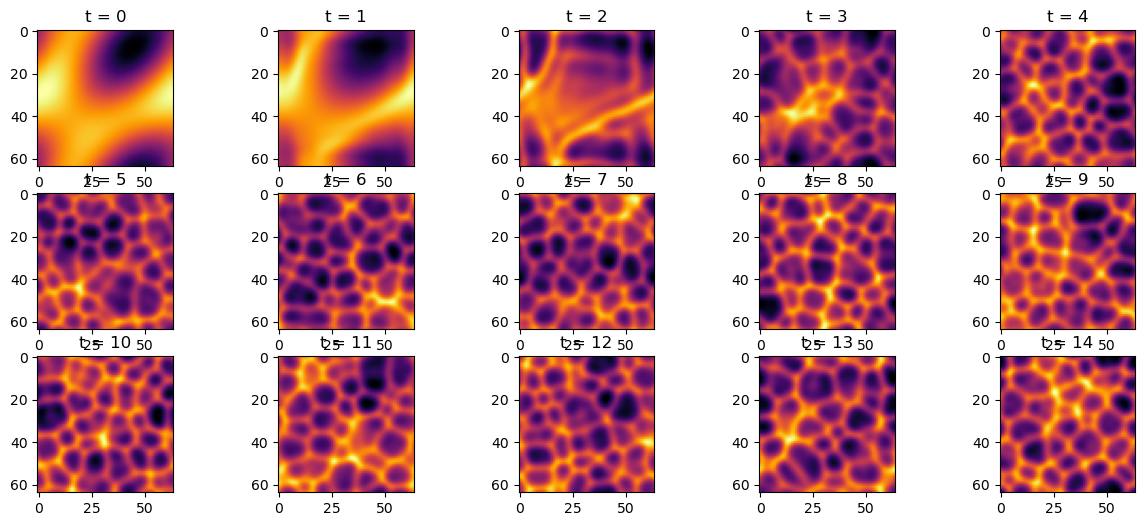

In [5]:
fig, axs = plt.subplots(3,5, figsize = (15,6))
axs= axs.ravel()

for i in range(result_array.shape[1]):
    axs[i].imshow(result_array[0,i], cmap = "inferno")
    axs[i].set_title("t = " + str(i))